<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook (and the image needs to be where this notebook is expecting it)" width="500 px" align="left">

# _*Random Terrain Generation*_

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

***
### Contributors
James R. Wootton, IBM Research
***

From 1980's *Rogue* to recent games like *No Man's Sky*, [randomly generated content](https://en.wikipedia.org/wiki/Procedural_generation#Video_games) has become an important part of game design. This content is not generated in a completely random way, but is instead subject to a variety of constraints, like looking good, providing unique experiences for the player in every random sample, forming a solvable level and allowing this solvability to be efficiently verified.

To satisfy these contraints, the procedure used to generate the random content can sometimes rely on reusing the same patterns over and over. Unfortunately this carries the risk of players recognising the patterns, which compromises the ability to keep providing unique experiences.

Procedural generation is therefore another area in which quantum computers could be very useful. Not only can it be used for new methods of generating random content, it can also provide new algorithms to analyse the solvability of classical methods.

In this notebook we perform a first experiment on quantum procedural generation. This will cover one of the simplest and most useful applications of procedural generation: the creation of random height maps.

One of the current most popular methods to do this is [Perlin noise](https://en.wikipedia.org/wiki/Perlin_noise). Here's a sample ([source](https://commons.wikimedia.org/wiki/File:Perlin_noise.jpg)).

![Perlin noise by Reedbeta on Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/d/da/Perlin_noise.jpg)

In this image, the white and black areas can be associated with mountains and valleys, respectively. This image could therefore be turned into mountainous terrain to explore in a game. In this notebook we will investigate how to generate something similar with Qiskit.

First, let's choose how many qubits to use.

In [1]:
n = 9

Next, let's work out what to do with them. We will make a method designed for current and near-term devices, which means making the most out of a few qubits. However, we will also want to generate images with thousands of points. To allow this, we can measure the probabilities for each of the $2^n$ possible output bit strings that are possible for $n$ qubits. We can then associate each bit string with a point, and the height of the map can be the probability of that point.

Getting all these probabilities will mean that we need a large number of shots, which is how many times we repeatedly run a quantum program to calculate statistics of the outputs.

In [2]:
shots = 4**n

This method is therefore not scalable to large $n$: it has exactly the kind of exponentially increasing run time that quantum computers usually aim to free us from. Other quantum methods for procedural generation will therefore be needed in the [NISQ era](https://arxiv.org/abs/1801.00862) of quantum computing and beyond.

For now, we need to choose a way of assigning each of the possible bit strings to a point. The most natural way to do this would be to respect the [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) of the bit strings. This is because the basic operations of quantum computing, single qubit gates and `cx` gates, only have the effect of flipping a single bit in a bit string. Strings that differ by only a single bit can therefore be regarded as 'closer' to each other than those that differ by more.

With this in mind, the set of all $n$-bit strings represents a hypercube: a shape that exists in $n$-dimensional space. This is a bit exotic for our needs, since we want the generate a 2D terrain map like the one depicted above. We therefore need a way to squash a hypercube onto a 2D surface.

This is done in the following cell. The dictionary `strings` is created, which has 2D coordinates `(x,y)` as keys and the corresponding bit string as values. The squashing procedure essentially uses the fact that a cube is two squares, with each point in one connected to its partner in the other. A tesseract is then two cubes connected similarly, and so on for higher dimensional hypercubes. But if we don't include all the possible connections, we can keep our not-quite-a-cube flat, and then do the same with the corresponding not-quite-a-tesseract, and so on.

The result is a square lattice. The four neighbours of each point are four of the $n$ hypercube neighbours of the corresponding string. So the strings are only close to strings that they should be close to, though at the cost of being far away from some of their hypercube neighbours.

In [3]:
import numpy as np

Lx = int(2**np.ceil(n/2))
Ly = int(2**np.floor(n/2))

strings = {}
for y in range(Ly):
    for x in range(Lx):
        strings[(x,y)] = ''

for (x,y) in strings:
    for j in range(n):
        if (j%2)==0:
            xx = np.floor(x/2**(j/2))
            strings[(x,y)] = str( int( ( xx + np.floor(xx/2) )%2 ) ) + strings[(x,y)]
        else:
            yy = np.floor(y/2**((j-1)/2))
            strings[(x,y)] = str( int( ( yy + np.floor(yy/2) )%2 ) ) + strings[(x,y)]

The squashed hypercube we obtain above is just one of exponentially many we could have got. To explore this space a bit, and not end up with the same grid every time, we can perform a suffle. This reorders the bits in all the bit strings in the same way. This ensures the resulting squashed hypercube has all the properties we need, while allowing for some variation with each run.

In [4]:
import random

order = [j for j in range(n)]
random.shuffle(order)

for (x,y) in strings:
    new_string = ''
    for j in order:
        new_string = strings[(x,y)][j] + new_string
    strings[(x,y)] = new_string

We can also assert a bit of control over the hypercube by choosing which string lives at the center (actucally, it will be just to the top right of the center). By default, we choose this to be the string with all `0`s.

In [5]:
center = '0'*n

In [6]:
current_center = strings[ ( int(np.floor(Lx/2)),int(np.floor(Ly/2)) ) ]
diff = ''
for j in range(n):
    diff += '0'*(current_center[j]==center[j]) + '1'*(current_center[j]!=center[j])
for (x,y) in strings:
        newstring = ''
        for j in range(n):
            newstring += strings[(x,y)][j]*(diff[j]=='0') + ('0'*(strings[(x,y)][j]=='1')+'1'*(strings[(x,y)][j]=='0'))*(diff[j]=='1')
        strings[(x,y)] = newstring

With these manipulations complete, we now create the dictionary `pos`, which is ordered in the opposite way to `strings`: it has the strings as keys and coordinates as values.

In [7]:
pos = {}
for y in range(Ly):
    for x in range(Lx):
        pos[strings[(x,y)]] = (x,y)

Now the grid is defined, we can deal with how to make an image of it. This is done with the following function, which will create a shaded block for each string at the positions defined by `pos`. It will also use `probs`, which will be a dictionary with the output strings as keys and their corresponding probabilities as values. The resulting shaded blockswill be darker for strings whose probability is low, and lighter for high probability strings.

By default, the lowest probabilities are made black, the highest are white and the scaling of the shading is logarithmic. These can be turned off with the `log` and `normalize` kwargs.

In [8]:
import matplotlib
import matplotlib.pyplot as plt

def plot_terrain(pos,probs,log=True,normalize=True):

    Z = {}
    for node in probs:
        if log:
            Z[node] = np.log(probs[node])
        else:
            Z[node] = probs[node]
        
    minZ = min(Z.values())
    maxZ = max(Z.values())
    colors = {}
    for node in Z:
        if normalize:
            z = (Z[node]-minZ)/(maxZ-minZ)
        else:
            z = Z[node]
        colors[node] = (z,z,z,1)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for node in pos:
        rect = matplotlib.patches.Rectangle(pos[node], 1, 1, color=colors[node])
        ax.add_patch(rect)
    plt.xlim([0, Lx])
    plt.ylim([0, Ly])
    plt.axis('off')
    plt.savefig('output.png',dpi=1000)
    plt.show()


Note that the plotting we are using won't be happy if all possible strings aren't present in `pos` with a non-zero probability. So we'll give all the outputs that don't appear a nominal probability of 1/`shots`.

Here's a function to produce such a `probs` from the results contain in a `job` object.

In [9]:
def get_probs(job):
    counts = job.result().get_counts()
    probs = {}
    for string in pos:
        try:
            probs[string] = counts[string]/shots
        except:
            probs[string] = 1/shots
    return probs

It's time to make and run a quantum circuit. Let's start with a trivial circuit, and so one that outputs all `0`s.

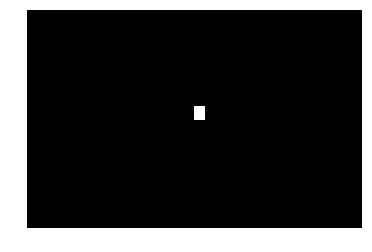

In [10]:
from qiskit import *

q = QuantumRegister(n)
c = ClassicalRegister(n)
qc = QuantumCircuit(q, c)

qc.measure(q, c)

backend = Aer.get_backend('qasm_simulator')

job = execute(qc, backend, shots=shots)

probs = get_probs(job)
plot_terrain(pos,probs)

Here we just get a single peak in the center. Not very interesting. To make a mountain, we need to spread out the probability. One way to do this is to simply use the noise present in a real device.

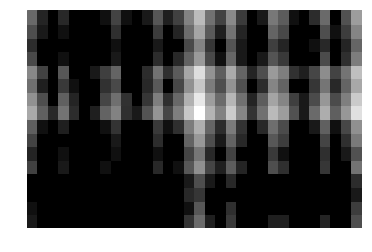

In [11]:
from qiskit.providers.aer import noise

IBMQ.load_accounts()

backend_to_simulate = IBMQ.get_backend('ibmq_16_melbourne')
noise_model = noise.device.basic_device_noise_model(backend_to_simulate.properties())
job = execute(qc, backend, shots=shots,noise_model=noise_model,basis_gates=noise_model.basis_gates)

probs = get_probs(job)
plot_terrain(pos,probs)

Here we have used noise in the system instead of trying to avoid it. This is another aspect of our method that makes it suitable for near-term devices.

Now let's try another quantum circuit. This time with a GHZ state.

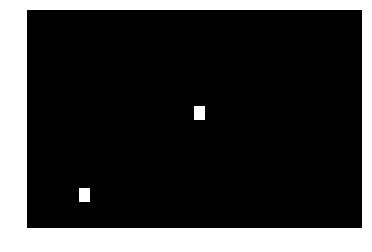

In [12]:
qc = QuantumCircuit(q, c)
qc.h(q[0])
for j in range(n-1):
    qc.cx(q[j],q[j+1])
qc.measure(q, c)

job = execute(qc, backend, shots=shots)

probs = get_probs(job)
plot_terrain(pos,probs)

Again, it is not so interesting. This time, let's spread out the probability by adding in some single qubit gates. Specifically, we'll try rotations around the y axis by a few different angles.


For rotations around the y axis by 0.0*pi


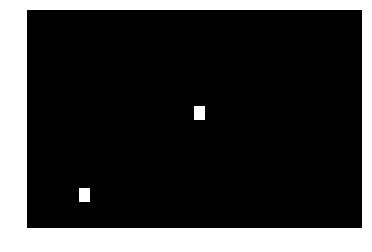


For rotations around the y axis by 0.1*pi


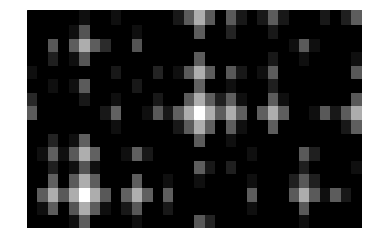


For rotations around the y axis by 0.2*pi


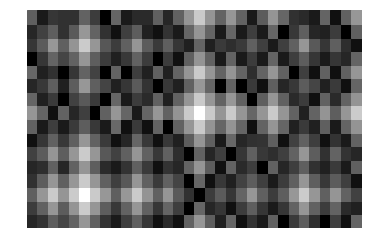


For rotations around the y axis by 0.3*pi


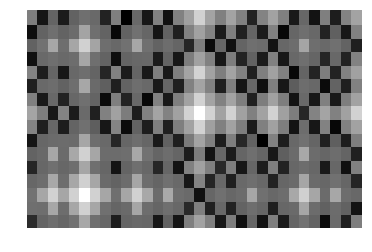


For rotations around the y axis by 0.4*pi


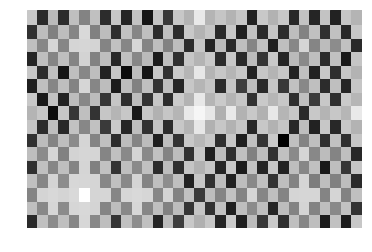


For rotations around the y axis by 0.5*pi


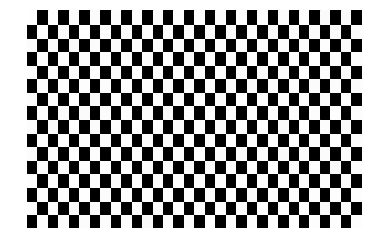

In [13]:
for frac in [0.0,0.1,0.2,0.3,0.4,0.5]:
    
    qc = QuantumCircuit(q, c)
    qc.h(q[0])
    for j in range(n-1):
        qc.cx(q[j],q[j+1])
    qc.ry(np.pi*frac,q)   
    qc.measure(q, c)

    job = execute(qc, backend, shots=shots)

    probs = get_probs(job)
    print('\nFor rotations around the y axis by '+str(frac)+'*pi')
    plot_terrain(pos,probs)

These take us from the twin peaks of the GHZ state to a checkerboard pattern, thanks to the interference effects in quantum states. We find some interesting patterns along the way.

These interference effects are one way that quantum procedural generation can avoid the playing 'seeing behind the curtain' and recognizing the way the random patterns are created: quantum effects are quite removed from human experience, and so we have less intuition that helps us recognize them.

So far we've experimented with just one or two peaks. For something that looks like Perlin noise, we need a constant density. For this we can set a density `rho`, and then use it to pick a random set of points. This can then be turned into a vector representing the quantum superposition of the corresponding bit strings.

In [14]:
rho = 0.1
N = int(rho*2**n)
state = [0]*(2**n)
for j in range(N):
    state[ int(random.choice(list(pos.keys())),2) ] = 1
Z = sum(np.absolute(state)**2)
state = [amp / np.sqrt(Z) for amp in state]

We can then initialize the circuit with this state, and again try using `ry` rotations by different angles.


For rotations around the y axis by 0.0*pi


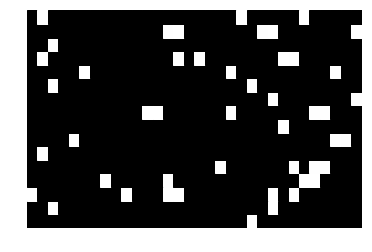


For rotations around the y axis by 0.1*pi


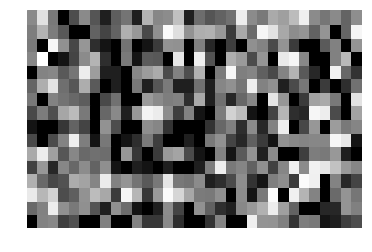


For rotations around the y axis by 0.2*pi


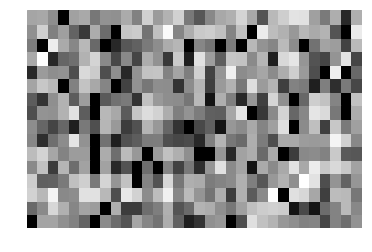


For rotations around the y axis by 0.3*pi


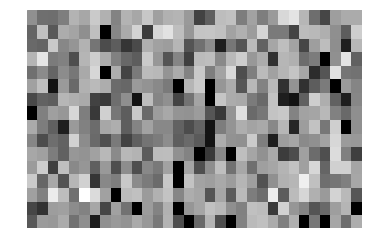


For rotations around the y axis by 0.4*pi


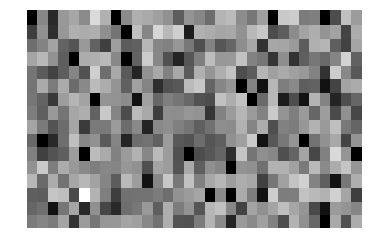


For rotations around the y axis by 0.5*pi


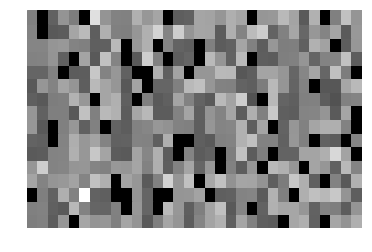

In [15]:
for frac in [0.0,0.1,0.2,0.3,0.4,0.5]:
    
    qc = QuantumCircuit(q, c)
    qc.initialize(state,q)
    qc.ry(np.pi*frac,q)   
    qc.measure(q, c)

    job = execute(qc, backend, shots=shots)

    probs = get_probs(job)
    print('\nFor rotations around the y axis by '+str(frac)+'*pi')
    plot_terrain(pos,probs)

We could also have spread out the peaks by simply using the noise of a real device. Since the process of creating our initial state is quite involved, this will have quite a lot of noise.

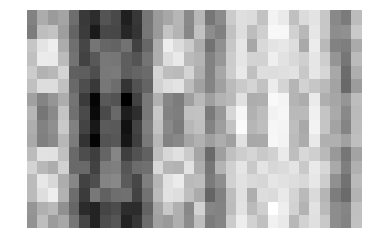

In [16]:
qc = QuantumCircuit(q, c)
qc.initialize(state,q)
qc.measure(q, c)

job = execute(qc, backend, shots=shots,noise_model=noise_model,basis_gates=noise_model.basis_gates)

probs = get_probs(job)
plot_terrain(pos,probs)

Clearly our Terrain maps are blockier than the example of Perlin noise shown at the top. This could be dealt with by adding more qubits, or simply by being careful in choosing how we apply the method. When generating terrain with Perlin noise, multiple layers are often used to create a good effect. Perhaps in future, some of those layers could be quantum.

For another example of generation images using qubits, see the [Quantum Animations](quantum_animations.ipynb) notebook.

In [ ]:
keywords = {'Topics': ['Creative','Games','Procedural generation','Images','Entanglement'], 'Commands': ['`ry`','`initialize','`noise_model`','`basic_device_noise_model`']}